In [72]:
import sentencepiece as spm
import pandas as pd
import numpy as np
import time

from sklearn.feature_extraction.text import *
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import nltk
import string
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [73]:
sp = spm.SentencePieceProcessor()
sp.Load('../mongolian_bert_sentencepiece/mn_uncased.model')

def sp_tokenize(w):
    return sp.EncodeAsPieces(w)

MAX_LEN = 512
stopwordsmn = ['аа','аанхаа','алив','ба','байдаг','байжээ','байна','байсаар','байсан',
               'байхаа','бас','бишүү','бол','болжээ','болно','болоо','бэ','вэ','гэж','гэжээ',
               'гэлтгүй','гэсэн','гэтэл','за','л','мөн','нь','тэр','уу','харин','хэн','ч',
               'энэ','ээ','юм','үү','?','', '.', ',', '-','ийн','ын','тай','г','ийг','д','н',
               'ний','дээр','юу']

def remove_stop_words(text):
    
    stop_words_removed = []

    for entry in text:
        sentences = nltk.sent_tokenize(entry)
        content_sentences_stopwords = []

        for sentence in sentences:
            tokens = nltk.word_tokenize(sentence)
            tokens = [w.lower() for w in tokens]
            table = str.maketrans('', '', string.punctuation)
            stripped = [w.translate(table) for w in tokens]
            words = [word for word in stripped if word.isalpha()]
            words_stopwords = [w for w in words if not w in stopwordsmn]

            content_sentences_stopwords.append(words_stopwords)

        stop_words_removed.append(content_sentences_stopwords)
        
        
    for i in range(len(stop_words_removed)):
        stop_words_removed[i] = list(itertools.chain(*stop_words_removed[i]))[:MAX_LEN]
        stop_words_removed[i] = " ".join(stop_words_removed[i])
        
    return stop_words_removed

In [74]:
df_path = '../../main_dataset/'
trained_model_and_fitted_encoder_path = '../models/'
plots_path = '../plots/'

#df = pd.read_csv(df_path + '1111_only_mn.csv')

url = 'https://drive.google.com/file/d/1qLoomeZbKcgdvAPa44JUOzRMjq04pmpI/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]

df = pd.read_csv(path)
df = df.loc[df['type_text'] != 'Өргөдөл']
df = df.reset_index(drop = True)
df.head()

,content,type_text
0,Дулааны тухай,Гомдол
1,Ерөнхий сайдтай уулзах. Жолоочийн эрх ашиг алд...,Санал хүсэлт
2,Нефтийн үйлдвэр байгуулах тухай.,Санал хүсэлт
3,Жолооны үнэмлэх яагаад хэвлэгдэхгүй байна ?,Санал хүсэлт
4,БГД Гэмтэл-н эмнэлгийн гадуурх хашааг нураах т...,Гомдол


In [75]:
num_idx = []

for i in range(df.shape[0]):
    for word in df['content'][i]:
        if word.isdigit():
            num_idx.append(i)
            break
            
nums_dropped = df.drop(index = num_idx)
nums_dropped = nums_dropped.reset_index(drop = True)

## Rows where content feature contained number was dropped

In [76]:
nums_dropped.shape

(25592, 2)

In [77]:
# Stratified train and test split
train, test = train_test_split(nums_dropped, test_size=0.1, random_state=999, stratify=nums_dropped['type_text'])

text_clf = Pipeline([('vect', CountVectorizer(tokenizer=sp_tokenize, lowercase=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, max_iter=5, random_state=0))])

t = time.time()
text_clf = text_clf.fit(train['content'], train['type_text'])
t = time.time()-t
print("Training time in seconds: ", t)

t = time.time()
predicted = text_clf.predict(test['content'])
t = time.time()-t
print("Prediction time in seconds: ", t)

print("Feature count:", len(text_clf.named_steps['vect'].vocabulary_))

acc = np.mean(predicted == test['type_text'])
print("Classifier accuracy: ", acc)

Training time in seconds:  2.0384628772735596
Prediction time in seconds:  0.2203841209411621
Feature count: 19524
Classifier accuracy:  0.79375


In [78]:
# Really messy here!
def return_sentence_len(text):
    sent_len = [len(sent) for sent in text]

    return sent_len

def return_sentence_len_dist(pred, data):
    # Test set indexes for corresponding classes
    pred_sanal_idx = np.where(pred == 'Санал хүсэлт')[0].tolist()
    pred_gomdol_idx = np.where(pred == 'Гомдол')[0].tolist()
    pred_shuumjlel_idx = np.where(pred == 'Шүүмжлэл')[0].tolist()
    pred_talarhal_idx = np.where(pred == 'Талархал')[0].tolist()

    # Test set distribution of content feature sentences
    pred_sanal_sentence_len = return_sentence_len(data.iloc[pred_sanal_idx]['content'])
    pred_gomdol_sentence_len = return_sentence_len(data.iloc[pred_gomdol_idx]['content'])
    pred_shuumjlel_sentence_len = return_sentence_len(data.iloc[pred_shuumjlel_idx]['content'])
    pred_talarhal_sentence_len = return_sentence_len(data.iloc[pred_talarhal_idx]['content'])
    
    return [pred_sanal_sentence_len, pred_gomdol_sentence_len, pred_shuumjlel_sentence_len, pred_talarhal_sentence_len]

In [79]:
# For creating plot for each predicted class
def single_hist_plot(val, label, save_path):
    fig, ax = plt.subplots(figsize = (10, 8))
    ax.set_title(f'Sentence length where model predicted "{label}"', fontsize = 18)

    ax.hist(val, color = 'green', alpha = 0.7);

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis = 'x', pad = 14, labelsize = 14)
    ax.tick_params(axis = 'y', pad = 5, labelsize = 10)

    ax.grid(alpha = 0.5, linestyle = '--', c = 'gray')
    fig.savefig(plots_path + save_path + f'{label}_length_distribution.png')
    
# Plotting all histograms on a single figure
def all_hist(val, save_path):
    fig, ax = plt.subplots(figsize = (10, 8))
    ax.set_title('Sentence length distibution for different classes', fontsize = 18)

    colors = ['green', 'red', 'yellow', 'blue']
    alphas = [0.7, 1, 1, 1]
    for i in range(4):
        ax.hist(val[i], color = colors[i], alpha = alphas[i]);

    ax.legend(['Санал Хүсэлт', 'Гомдол', 'Шүүмжлэл', 'Талархал'], fontsize = 14, frameon = False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(axis = 'x', pad = 14, labelsize = 14)
    ax.tick_params(axis = 'y', pad = 5, labelsize = 10)

    ax.grid(alpha = 0.5, linestyle = '--', c = 'gray')
    fig.savefig(plots_path + f'{save_path}.png')

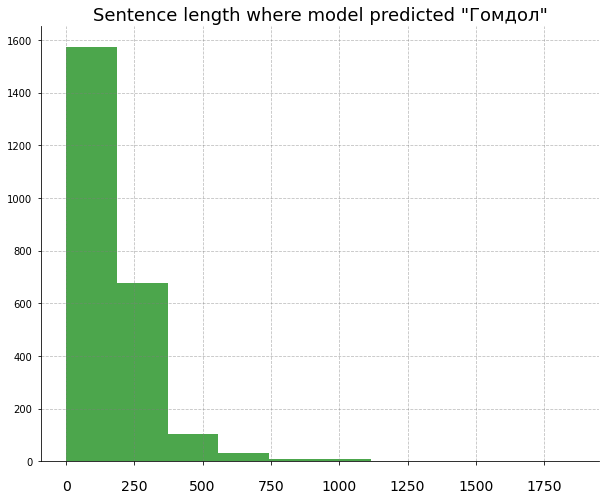

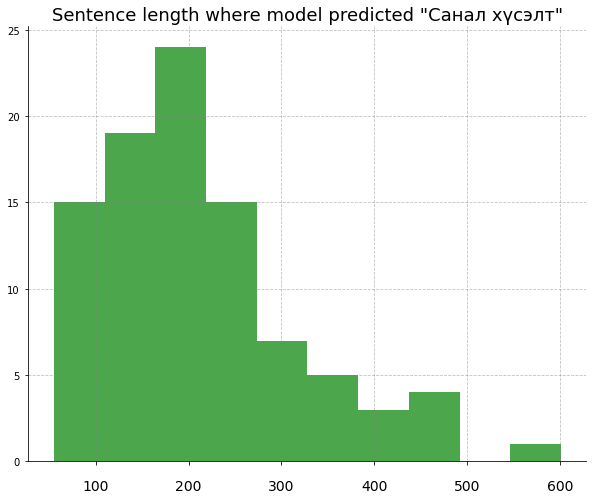

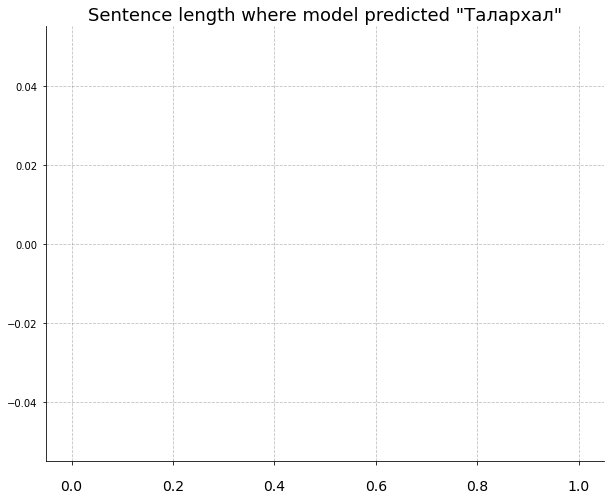

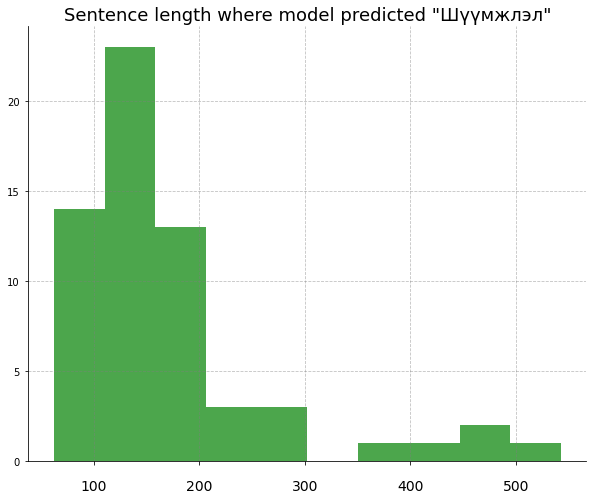

In [80]:
sentence_len_dist = return_sentence_len_dist(predicted, test)
labels = np.unique(nums_dropped['type_text'])

for i in range(4):
    single_hist_plot(sentence_len_dist[i], labels[i], 'svm_nums_dropped/')

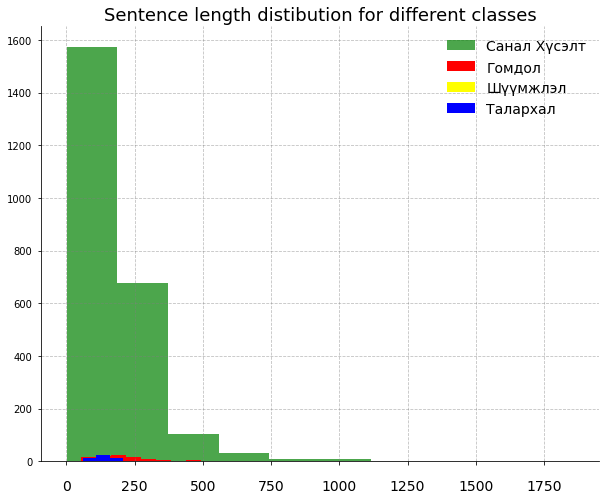

In [81]:
all_hist(sentence_len_dist, 'svm_nums_dropped/pred_sent_dist')

## Here we only remove the numbers, stopwords and keep the rows 

In [82]:
df.shape

(76063, 2)

In [83]:
import re

# Only removing numbers and hyphens
df['content'] = [re.sub('\d', '', sent) for sent in df['content']]
df['content'] = [re.sub(' \s+', ' ', sent) for sent in df['content']]
# Removing stopwords
df['content'] = remove_stop_words(df['content'])

In [84]:
# Stratified train and test split
train, test = train_test_split(df, test_size=0.1, random_state=999, stratify=df['type_text'])

# adding class_weight parameter to SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer(tokenizer=sp_tokenize, lowercase=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, 
                                           max_iter=5, random_state=0, class_weight = 'balanced'))])

t = time.time()
text_clf = text_clf.fit(train['content'], train['type_text'])
t = time.time()-t
print("Training time in seconds: ", t)

t = time.time()
predicted = text_clf.predict(test['content'])
t = time.time()-t
print("Prediction time in seconds: ", t)

print("Feature count:", len(text_clf.named_steps['vect'].vocabulary_))

acc = np.mean(predicted == test['type_text'])
print("Classifier accuracy: ", acc)

Training time in seconds:  6.23710298538208
Prediction time in seconds:  0.920435905456543
Feature count: 25689
Classifier accuracy:  0.749046930458788


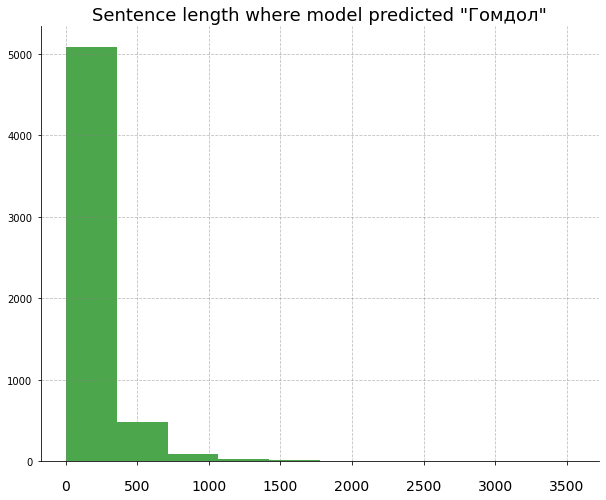

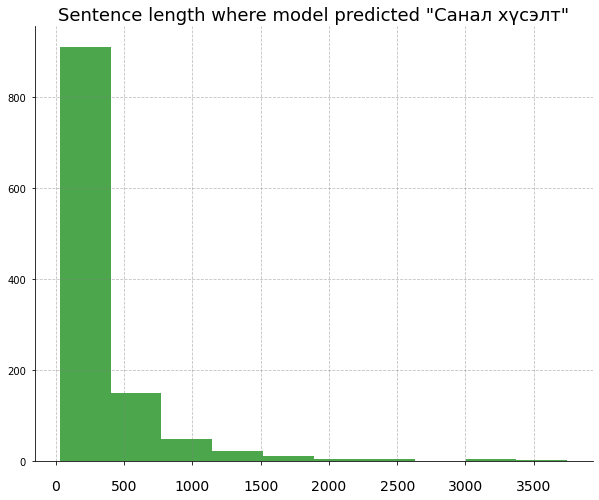

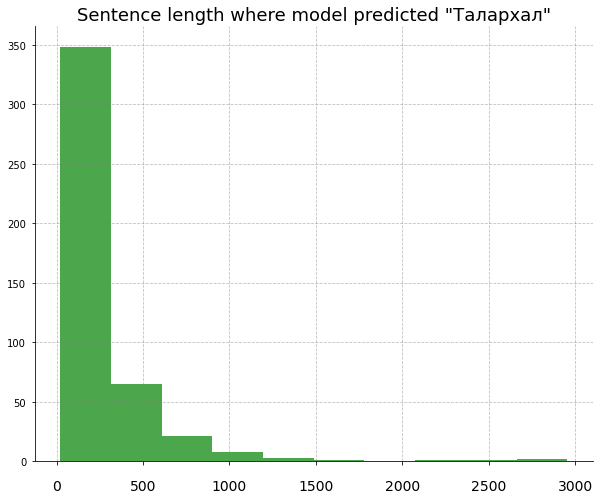

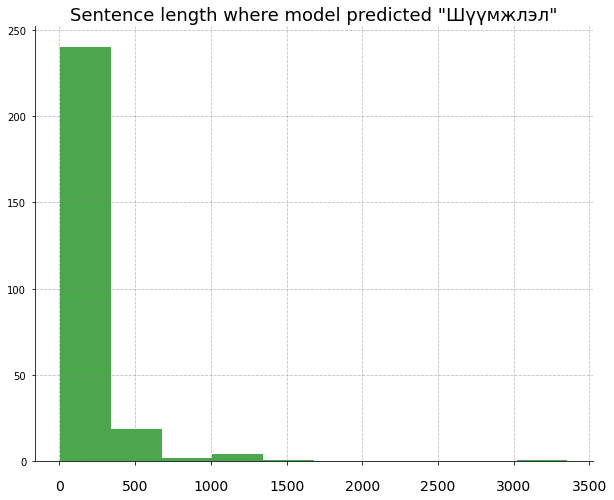

In [85]:
sentence_len_dist = return_sentence_len_dist(predicted, test)
labels = np.unique(df['type_text'])

for i in range(4):
    single_hist_plot(sentence_len_dist[i], labels[i], 'svm_nums_not_dropped/')

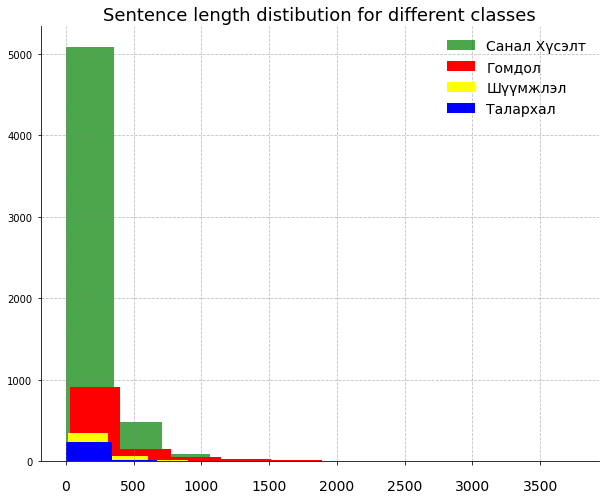

In [86]:
all_hist(sentence_len_dist, 'svm_nums_not_dropped/pred_sent_dist')